In [39]:

from qutip import basis, sigmax, sigmaz, sigmay, Options 
from qutip.solver.heom import DrudeLorentzBath
from qutip.solver.heom import HEOMSolver
from qutip.solver.heom import DrudeLorentzPadeBath
from qutip.solver.heom import BathExponent
import math
from scipy.fft import fft, ifft 

import matplotlib.pyplot as plt
import qutip

import numpy as np 
import time 


print("import erfolgreich ")

# More flexibel solver for custom bath
from qutip.solver.heom import HSolverDL
from qutip.solver.heom import BosonicBath
print(math.cos(np.pi),np.cos(0))

import erfolgreich 
-1.0 1.0


In [40]:
# Parameters

#kb=1.380649*10**(-23)
#h=1.05457*10**(-34)

w0 = 1 # Alle frequenzen in einheiten der resonanzfrequenz. 
g = ((1/20)*4*np.pi)**2
print(g)
# coupling strengt in omega
steps= 2000
tmax=10
tlist = [0, tmax, steps]
kb=h=1
tl=4  #in 1/w0
c=0.1
gamma1=1
g=0.00648




def Temp(omega,n):
    T=h*omega/(kb*(np.log((1/n)+1)))
    return T

def nb(w,t):
    return 1/(np.exp(w/t)-1)


nB=0.04
T=0.05
#T=10 # Einheit von  hb*omega durch kb 
beta = 1. / T
gamma=2 # cut off frequency in einheiten  von omega. Steigt mit temperatur. amplitude der noise spielt auch eine rolle 
lam=(g**2) #"""Proportional zu g² aber da kommen noch andere faktorren dazu""" # teil der  noise  rate for correlation, 
#lam= (g**2) *(np.log(1) + np.log(gamma))
#lam= g/(4*np.pi)
print(Temp(1,0.00001))
#print("lam=",lam, "T=", T, "gamma=",gamma,"g=",g)

0.3947841760435743
0.08685882093641431


In [41]:
#The system Hamiltonian:
P11=basis(2,0)*basis(2,0).dag()
P22=basis(2,1)*basis(2,1).dag()
P12=basis(2,0)*basis(2,1).dag()
P21=basis(2,1)*basis(2,0).dag()


# Initial state of the system:
rho0 = P22


Q=(P12+P21)#*(np.exp(-1j*x) + np.exp(1j*x)))+g*((P12+P21)*(np.exp(+1j*x) + np.exp(-1j*x)))
#H_sys = w0*sigmaz()+g*((P12+P21))#*(np.exp(-1j*x) + np.exp(1j*x)))+g*((P12+P21)*(np.exp(+1j*x) + np.exp(-1j*x)))
H_sys=w0*(P22+P11)
print(P12+P21,basis(2,0))


Quantum object: dims=[[2], [2]], shape=(2, 2), type='oper', dtype=Dense, isherm=True
Qobj data =
[[0. 1.]
 [1. 0.]] Quantum object: dims=[[2], [1]], shape=(2, 1), type='ket', dtype=Dense
Qobj data =
[[1.]
 [0.]]


In [42]:
def cot(x):
    return 1. / np.tan(x)

beta = 1. / T

# Number of expansion terms to calculate:
Nk =16
#beta=10000000000000000000000000000000000000000000000
# C_real expansion terms:
ck_real = [(lam * gamma*np.cosh(gamma*tl))**2 / np.tan(gamma / (2 * T))]
ck_real.extend([
    ((8 * lam * gamma * T * np.pi * k * T *(np.cosh(2 * np.pi * k * T*tl))**2)/
        ((2 * np.pi * k * T)**2 - gamma**2))
    for k in range(1, Nk + 1)
])
vk_real = [gamma]
vk_real.extend([2 * np.pi * k * T for k in range(1, Nk + 1)])

# C_imag expansion terms (this is the full expansion):
ck_imag = [lam * gamma * (-1.0)*(np.cosh(gamma*tl))**2]
vk_imag = [gamma]
Bad = BosonicBath(Q, ck_real, vk_real, ck_imag, vk_imag)
#BadDefault=DrudeLorentzBath(Q, g**2, 2, T, Nk)
print(ck_real)

[0.007003491449477806, -4.878032057758787e-06, -0.00011300075329764373, -0.0023954285689114364, -0.0506327290546569, -1.234098498067377, -62.691160125338506, 482.66310736498747, 2457.861778478542, 19797.15623472804, 184799.9645081003, 1854652.2812455825, 19425559.019802563, 209242878.90772784, 2298753878.1045485, 25625851348.352585, 288900013659.5938]


In [43]:
#Bad Mey=exp(-w/wc)
# C_real expansion terms:
tl=2
Nk=9
gamma=2
ck_real = [0]
ck_real.extend([
    (np.exp(1j*2 * np.pi * k * T/gamma)*(np.cosh(2 * np.pi * k * T*tl))**2)
    for k in range(1, Nk + 1)
])
vk_real = [0]
vk_real.extend([2 * np.pi * k * T for k in range(1, Nk + 1)])

# C_imag expansion terms (this is the full expansion):
ck_imag = [0]
vk_imag = [0]
BadMey = BosonicBath(Q, ck_real, vk_real, ck_imag, vk_imag)
#BadDefault=DrudeLorentzBath(Q, g**2, 2, T, Nk)
print(ck_real)

[0, (1.431702440888771+0.2267593898114405j), (3.430053452894241+1.114491925977028j), (10.112760613818931+5.152708897385646j), (31.230603771369072+22.690361815184243j), (95.01632873354099+95.01632873354097j), (276.7728390686081+380.94513177150986j), (750.5367180140503+1473.0112475417318j), (1794.5852708695686+5523.165544212464j), (3191.816876367228+20152.338637728943j)]


In [44]:

def cot(x):
    return 1. / np.tan(x)

beta = 1. / T

# Number of expansion terms to calculate:


# C_real expansion terms:
ck_real = [lam * gamma / np.tan(gamma / (2 * T))]
ck_real.extend([
    (8 * lam * gamma * T * np.pi * k * T /
        ((2 * np.pi * k * T)**2 - gamma**2))
    for k in range(1, Nk + 1)
])
vk_real = [gamma]
vk_real.extend([2 * np.pi * k * T for k in range(1, Nk + 1)])

# C_imag expansion terms (this is the full expansion):
ck_imag = [lam * gamma * (-1.0)]
vk_imag = [gamma]
Bad1 = BosonicBath(Q, ck_real, vk_real, ck_imag, vk_imag)
BadDefault=DrudeLorentzBath(Q, g**2, 2, T, Nk)

In [45]:




# Anzahl der expansion rho_n:


# C_real expansion terms:
ck_real2 = [lam * gamma / np.tan(gamma / (2 * T))
        #*np.cosh(gamma*tl)**2
        ]
ck_real2.extend([
    (8 * lam * gamma * T * np.pi * k * T /
        ((2 * np.pi * k * T)**2 - gamma**2))#*x*np.cosh(2 * np.pi * k * T*tl)**2
    for k in range(1, Nk + 1)
])
vk_real2 = [gamma+tl]
vk_real2.extend([2 * np.pi * k * T+2*tl*k*np.pi for k in range(1, Nk + 1)])

# C_imag expansion terms (this is the full expansion):
ck_imag2 = [lam * gamma* (-1.0)+tl*gamma #*x*np.cosh(gamma*tl)**2
        ]
vk_imag2 = [gamma-tl*gamma]

Bad2 = BosonicBath(Q, ck_real2, vk_real2, ck_imag2, vk_imag2)
print(ck_real)

[3.753900684561718e-05, -1.3525399061386564e-06, -2.927241831897413e-06, -5.087195660037956e-06, -8.718657175810698e-06, -1.7214775788334206e-05, -7.083690116019616e-05, 4.417702790072759e-05, 1.8222534501504525e-05, 1.1889211530017751e-05]


In [46]:





# C_real expansion terms:
ck_real3 = [lam * gamma / np.tan(gamma / (2 * T))
        #*np.cosh(gamma*tl)**2
        ]
ck_real3.extend([
    (8 * lam * gamma * T * np.pi * k * T /
        ((2 * np.pi * k * T)**2 - gamma**2))#*x*np.cosh(2 * np.pi * k * T*tl)**2
    for k in range(1, Nk + 1)
])
vk_real3 = [gamma-tl*gamma]
vk_real3.extend([2 * np.pi * k * T-2*tl*k*np.pi for k in range(1, Nk + 1)])

# C_imag expansion terms (this is the full expansion):
ck_imag3 = [lam * gamma* (-1.0) #*x*np.cosh(gamma*tl)**2
        ]
vk_imag3 = [gamma+tl*gamma]

Bad3 = BosonicBath(Q, ck_real3, vk_real3, ck_imag3, vk_imag3)
print(ck_real)
Baths=[]
Baths.append(Bad1)
Baths.append(Bad2)
Baths.append(Bad3)

[3.753900684561718e-05, -1.3525399061386564e-06, -2.927241831897413e-06, -5.087195660037956e-06, -8.718657175810698e-06, -1.7214775788334206e-05, -7.083690116019616e-05, 4.417702790072759e-05, 1.8222534501504525e-05, 1.1889211530017751e-05]


In [47]:
#Nk=15
# C_real expansion terms:
ck_realf = [(1j*c/gamma1) / np.tan((1j*gamma1+w0)/ (2 * T))*(np.cos(w0+1j*gamma1)*tl)**2, (1j*c/gamma1) / np.tan((-1j*gamma1+w0)/ (2 * T))*(np.cos(w0-1j*gamma1)*tl)**2
]#*np.cosh(gamma*tl)
#ck_realf.append([(1j*c/gamma1) / np.tan((1j*gamma1+w0)/ (2 * T))*(np.cos(w0-1j*gamma1)*tl)**2])
ck_realf.extend([
    (-2*c  * T * np.pi * k * T)*np.cosh(2 * np.pi * k * T*tl)**2/
        ((w0**2 - 4j*k *w0- np.pi- 4* k**2* np.pi**2 +  gamma1**2))
    for k in range(1, Nk + 1)
])
vk_realf = [1j*w0+gamma1,1j*w0-gamma1
]
#vk_realf.append([1j*w0-gamma1])
vk_realf.extend([2 * np.pi * k * T for k in range(1, Nk + 1)])

# C_imag expansion terms (this is the full expansion):
ck_imagf = [(1j*c/gamma1 )*np.cos((w0-1j*gamma1)*tl)**2,(-1j*c/gamma1 )*np.cos((w0+1j*gamma1)*tl)**2
]
#ck_imagf.append([(1j*c/gamma1 )*np.cos((w0-1j*gamma1)*tl)**2
#])
vk_imagf = [1j*  w0 - gamma1,1j*w0+gamma1]
#vk_imagf.append([1j*w0-gamma1])
Badf = BosonicBath(Q, ck_realf, vk_realf, ck_imagf, vk_imagf)
print("lam=",lam, "T=", T, "gamma=",gamma,ck_realf)
#Baths=[]
#Baths.append(Bad1)
#Baths.append(Bad2)
print(ck_imagf)

lam= 4.19904e-05 T= 0.05 gamma= 2 [(-0.11312516477116584-0.6595789687975572j), (0.11312516477116584-0.6595789687975572j), (5.55164383737976e-05-5.466905401673148e-06j), (7.10557300455869e-05-3.5738889074728666e-06j), (0.00014987964138956289-5.04578219240707e-06j), (0.00038305499523153946-9.685391922161128e-06j), (0.0010676365725095043-2.1609844674129794e-05j), (0.003119186467067206-5.263100179771355e-05j), (0.009389450742616993-0.000135827023413352j), (0.028865967073743237-0.00036542663451719917j), (0.09015984189047582-0.0010146490937078488j)]
[(1.0326538715766516-0.8424926095160203j), (1.0326538715766516+0.8424926095160203j)]


def C(tlist,sigma,mu):
    eta_list = []
    gamma_list  =[]
    

    eta_0 = 0.5*Gamma*W*f_approx(1.0j*beta*W)

    gamma_0 = W - sigma*1.0j*mu
    eta_list.append(eta_0)
    gamma_list.append(gamma_0)
    if lmax>0:
        for l in range(1,lmax+1):
            eta_list.append(-1.0j*(kappa[l]/beta)*Gamma*W**2/(-(epsilon[l]**2/beta**2)+W**2))
            gamma_list.append(epsilon[l]/beta - sigma*1.0j*mu)
    c_tot = []
    for t in tlist:
        c_tot.append(sum([eta_list[l]*exp(-gamma_list[l]*t) for l in range(lmax+1)]))
    return c_tot, eta_list, gamma_list
 

def c_t_L_num(t,sigma,mu):
    
    integrand = lambda w: (1/(2*pi))*exp(sigma*1.0j*w*t)*Gamma_w(w,mu)*f(sigma*beta*(w-mu))
    def real_func(x):
        return real(integrand(x))
    def imag_func(x):
        return imag(integrand(x))
    #return quad(integrand,-np.inf,np.inf)[0]
    # This bounds must be increased if W is increased
    # But this integration is quite unstable for large frequencies.
    
    a= -50
    b= 50
    real_integral = quad(real_func, a, b)
    imag_integral = quad(imag_func, a, b)
    return real_integral[0] + 1.0j * imag_integral[0]

In [48]:


tlist = np.linspace(0,5, 10000)


10.0%. Run time:  13.47s. Est. time left: 00:00:02:01
20.0%. Run time:  27.83s. Est. time left: 00:00:01:51
30.0%. Run time:  41.70s. Est. time left: 00:00:01:37
40.0%. Run time:  54.94s. Est. time left: 00:00:01:22
50.0%. Run time:  68.02s. Est. time left: 00:00:01:08
60.0%. Run time:  78.91s. Est. time left: 00:00:00:52
70.0%. Run time:  86.52s. Est. time left: 00:00:00:37
80.0%. Run time:  93.79s. Est. time left: 00:00:00:23
90.0%. Run time: 101.05s. Est. time left: 00:00:00:11
100.0%. Run time: 108.29s. Est. time left: 00:00:00:00
Total run time: 108.29s
Quantum object: dims=[[2], [2]], shape=(2, 2), type='oper', dtype=Dense, isherm=True
Qobj data =
[[0. 0.]
 [0. 1.]] Quantum object: dims=[[2], [2]], shape=(2, 2), type='oper', dtype=Dense, isherm=True
Qobj data =
[[0. 0.]
 [0. 1.]]


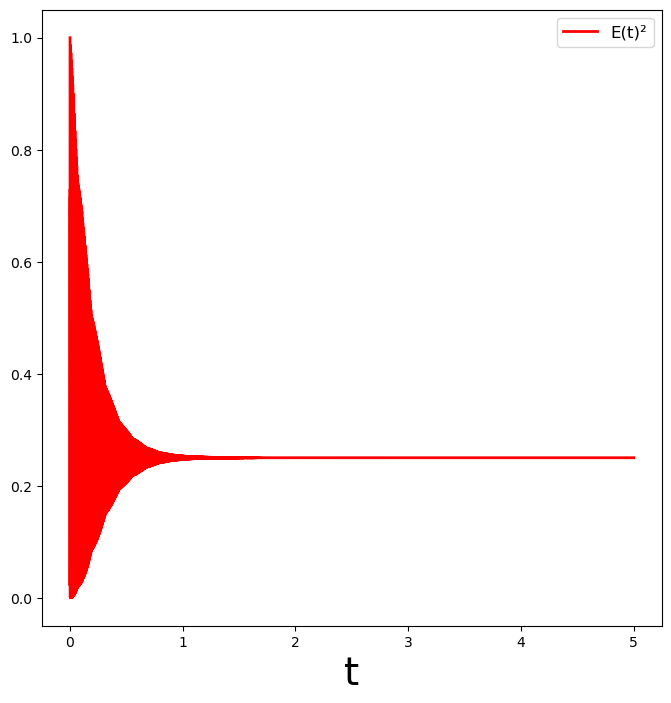

In [49]:
#tlist = [0, tmax, steps]
max_depth=1
options = {"nsteps": 1500_000}
#options = Options(atol=1e-2, rtol=1e-2)
solver = HEOMSolver(H_sys, Bad, max_depth=max_depth, options=options)

#Gibt einen  ausdruck der zeit an. 

# times to evaluate the system state at
#result = solver.run(rho0, tlist)
# Define the operators that measure the populations of the two
# system states:
P11p = basis(2,0) * basis(2,0).dag()
P22p = basis(2,1) * basis(2,1).dag()

# Define the operator that measures the 0, 1 element of density matrix
# (corresonding to coherence):


# Define the operators that measure the populations of the two
# system states:
P11p = basis(2,0) * basis(2,0).dag()
P22p = basis(2,1) * basis(2,1).dag()
E=basis(2,1) * basis(2,1).dag()*(basis(2,1) * basis(2,1).dag()).dag()
# Define the operator that measures the 0, 1 element of density matrix
# (corresonding to coherence):
P12p = basis(2,0) * basis(2,1).dag()
P21p = basis(2,1) * basis(2,0).dag()
# Run the solver:

result_HEOM = solver.run(rho0, tlist, e_ops={"11": P11p, "21": P21p, "12": P12p, "22": P22p,"E":E})
#result_HEOM = solver.run(rho0, tlist, e_ops={"22": P22p})
# Plot the results:
fig, axes = plt.subplots(1, 1, sharex=True, figsize=(8,8))
#axes.plot(result_HEOM.times, result_HEOM.e_data["12"], 'b', linewidth=2, label="12")
#axes.plot(result_HEOM.times, np.imag(result_HEOM.e_data["21"]), 'r', linewidth=2, label="21")
#axes.plot(result_HEOM.times, result_HEOM.e_data["11"], 'g', linewidth=2, label="11")
#axes.plot(result_HEOM.times, result_HEOM.e_data["22"], 'b', linewidth=2, label="22")
axes.plot(result_HEOM.times, (np.abs(result_HEOM.e_data["22"]))**2, 'r', linewidth=2, label="E(t)²")
axes.set_xlabel(r't', fontsize=28)
axes.legend(loc=0, fontsize=12)
print(P22p,E)


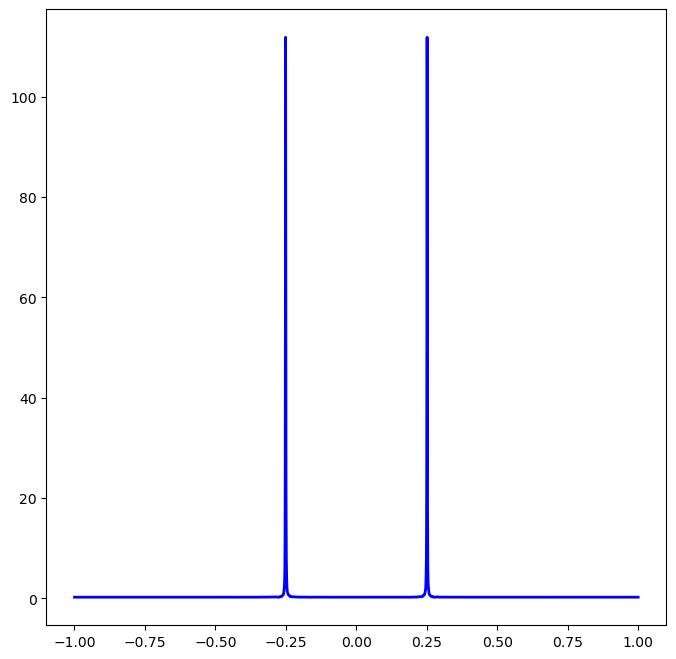

IndexError: index 9999 is out of bounds for axis 0 with size 9999

In [50]:
tlist = np.linspace(-gamma/2,gamma/2, 9992+8)
#print( result_HEOM.e_data["21"])

x= result_HEOM.e_data["22"]
y = fft(x)
y = np.delete(y, 0)
tlist=np.delete(tlist, 0)

fig, axes = plt.subplots(1, 1, sharex=True, figsize=(8,8))
axes.plot(tlist, y, 'b', linewidth=2, label="Fourier")
plt.show()
print(y[9999])

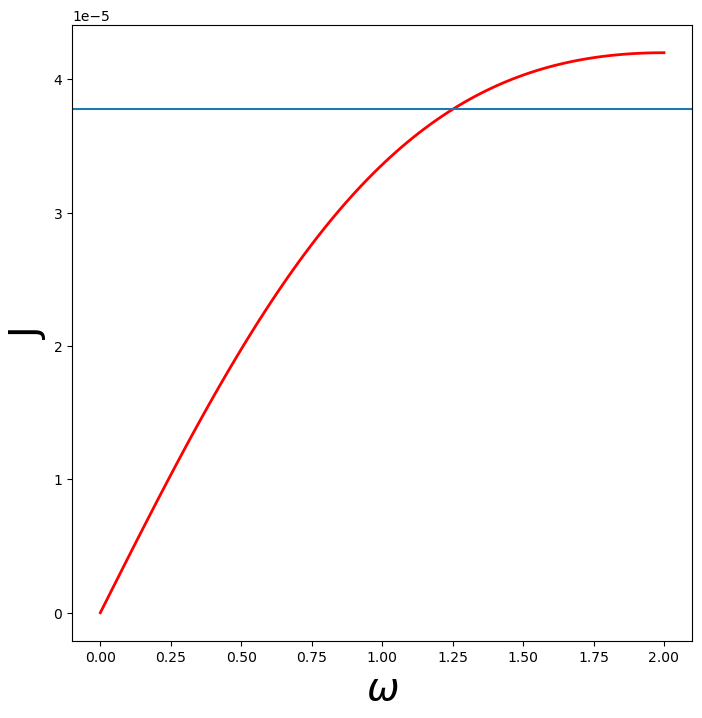

In [ ]:
#lam=g**2*200
#gamma=30
#lam=g**2

def plot_spectral_density():
    """ Drude-Lorentz spectral density muss zuerst in normale spectral density umgerechnet werden """
    wk = np.linspace(0, 2, 100)
    J = wk * 2 * lam * gamma / (gamma**2 + wk**2)
    J2=c/((w0-wk)**2+((gamma1**2) ))

    fig, axes = plt.subplots(1, 1, sharex=True, figsize=(8,8))
    axes.plot(wk, J, 'r', linewidth=2)
    
    #axes.plot(wk, J2, 'b', linewidth=2)
    axes.set_xlabel(r'$\omega$', fontsize=28)
    axes.set_ylabel(r'J', fontsize=28)
    axes.axhline(0.006148**2)
plot_spectral_density()

plt.show()

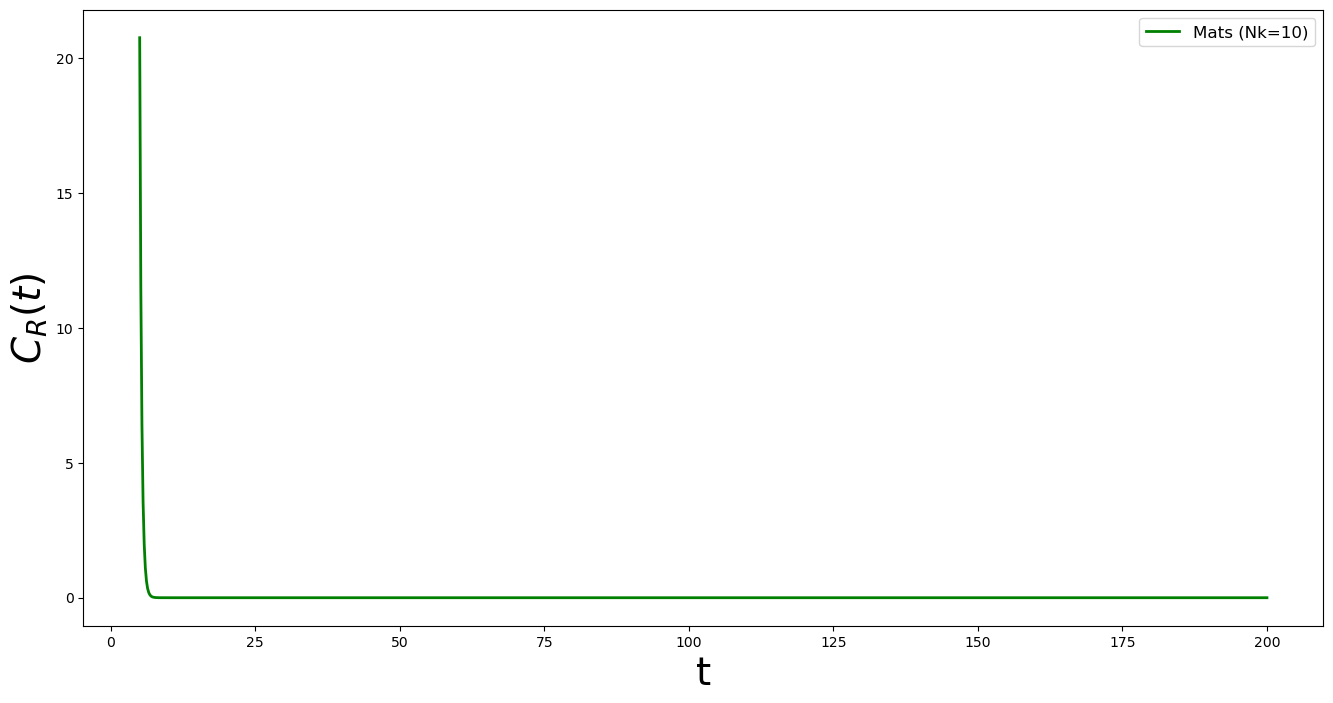

In [ ]:
Del=g**2

tlist = np.linspace(5,200, 1000)
matsBath = DrudeLorentzBath(Q, lam=lam, gamma=gamma, T=T, Nk=Nk)
padeBath = DrudeLorentzPadeBath(Q, lam=lam, gamma=gamma, T=T, Nk=Nk)

# We will compare against a summation of {lmaxmats} Matsubara terms
lmaxmats = 15000
exactBath = DrudeLorentzBath(Q, lam=lam, gamma=gamma, T=T, Nk=lmaxmats, combine=False)

# Real and imag. parts of the correlation functions:
def CR(bath, t):
    result = 0
    for exp in bath.exponents:
        if exp.type == BathExponent.types['R'] or exp.type == BathExponent.types['RI']:
            result += exp.ck * np.exp(-exp.vk * t)
    return result

def CI(bath, t):
    result = 0
    for exp in bath.exponents:
        if exp.type == BathExponent.types['I']:
            result += exp.ck * np.exp(exp.vk * t)
        if exp.type == BathExponent.types['RI']:
            result += exp.ck2 * np.exp(exp.vk * t)
    return result

fig, (ax1) = plt.subplots(ncols=1, sharey=True, figsize=(16, 8))

#ax1.plot(tlist, CR(exactBath, tlist), "r", linewidth=2, label=f"Mats (Nk={lmaxmats})")
ax1.plot(tlist, CR(Bad, tlist), "g", linewidth=2, label=f"Mats (Nk={Nk})")
#ax1.plot(tlist, CR(padeBath, tlist), "b--", linewidth=2, label=f"Pade (Nk={Nk})")

ax1.set_xlabel(r't', fontsize=28)
ax1.set_ylabel(r"$C_R(t)$", fontsize=28)
ax1.legend(loc=0, fontsize=12)

#tlist2=tlist[0:50]
#ax2.plot(tlist2, np.abs(CR(matsBath, tlist2) - CR(exactBath, tlist2)), "g", linewidth=2, label=f"Mats Error")
#ax2.plot(tlist2, np.abs(CR(padeBath, tlist2) - CR(exactBath, tlist2)), "b--", linewidth=2, label=f"Pade Error")

#ax2.set_xlabel(r't', fontsize=28)
#ax2.legend(loc=0, fontsize=12)
pass

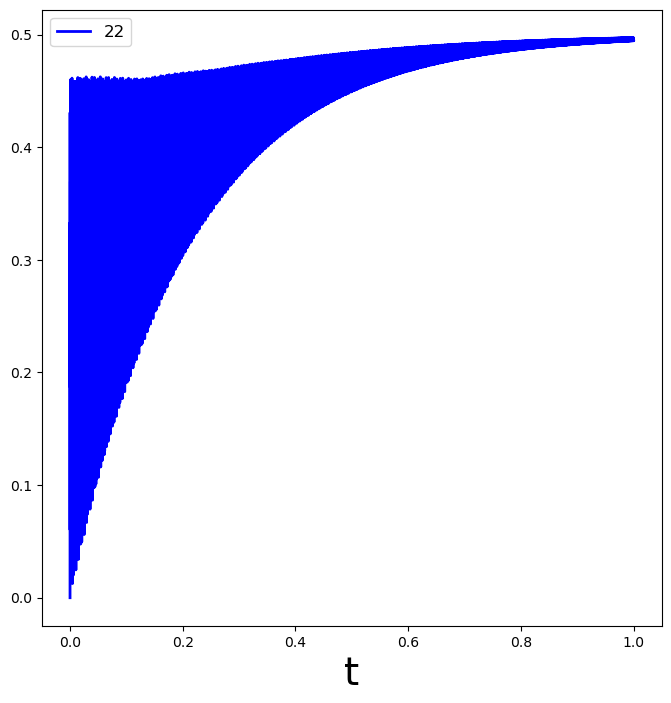

In [ ]:
tlist = np.linspace(0, 100, 1000)
fig, axes = plt.subplots(1, 1, sharex=True, figsize=(8,8))
#axes.plot(result_HEOM.times, result_HEOM.e_data["12"], 'b', linewidth=2, label="12")
#axes.plot(result_HEOM.times, np.imag(result_HEOM.e_data["21"]), 'r', linewidth=2, label="21")
#axes.plot(result_HEOM.times, result_HEOM.e_data["11"], 'g', linewidth=2, label="11")
axes.plot(result_HEOM.times, result_HEOM.e_data["11"], 'b', linewidth=2, label="22")
#axes.plot(result_HEOM.times, (np.abs(result_HEOM.e_data["E"]))**2, 'r', linewidth=2, label="E(t)²")
axes.set_xlabel(r't', fontsize=28)
axes.legend(loc=0, fontsize=12)
#plt.show()

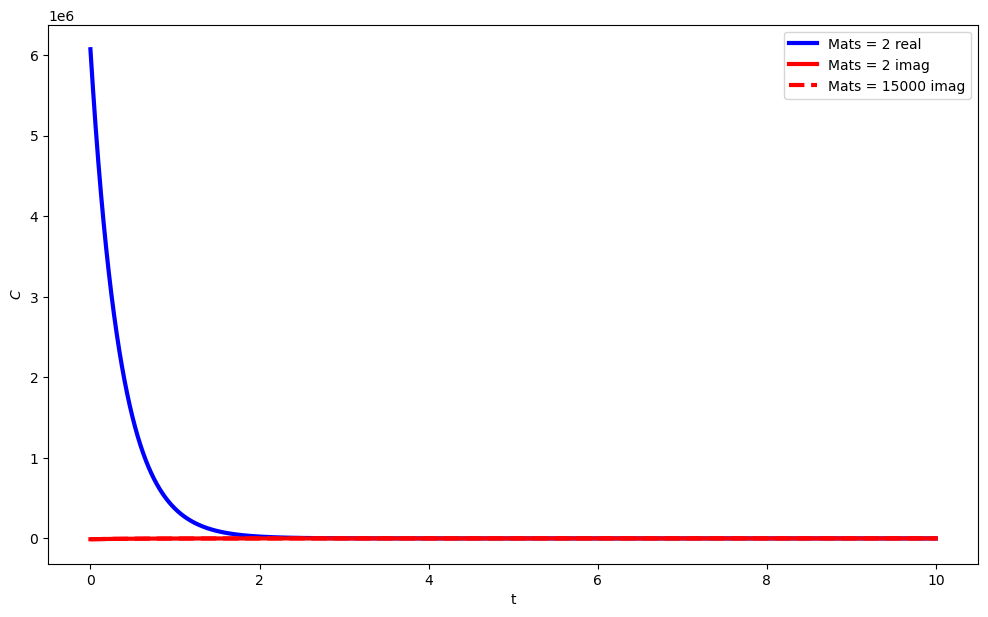

In [ ]:
def dl_corr_approx(t, nk):
    """ Drude-Lorenz correlation function approximation.
    
        Approximates the correlation function at each time t to nk exponents.
    """
    
    c = lam * gamma * (-1.0j + cot(gamma / (2 * T))) * np.exp(-gamma * t)*np.cosh( gamma*tl)**2
    for k in range(1, nk):
        vk = 2 * np.pi * k * T
        c += (4 * lam * gamma * T * vk / (vk**2 - gamma**2))  * np.exp(-vk * t)*np.cosh(vk*tl)**2
    return c


def plot_correlation_expansion_divergence(): 
    """ We plot the correlation function with a large number of Matsubara terms to show that
        the real part is slowly diverging at t = 0.
    """
    t = np.linspace(0, 10, 10000)
    # correlation coefficients with 15k and 2 terms
    corr_15k = dl_corr_approx(t, 15)
    corr_2 = dl_corr_approx(t, 10)

    fig, ax1 = plt.subplots(figsize=(12, 7))

    ax1.plot(t, np.real(corr_2), color="b", linewidth=3, label= r"Mats = 2 real")
    ax1.plot(t, np.imag(corr_2), color="r", linewidth=3, label= r"Mats = 2 imag")
    #ax1.plot(t, np.real(corr_15k), "b--", linewidth=3, label= r"Mats = 15000 real")
    ax1.plot(t, np.imag(corr_15k), "r--", linewidth=3, label= r"Mats = 15000 imag")

    ax1.set_xlabel("t")
    ax1.set_ylabel(r"$C$")
    ax1.legend()
    
plot_correlation_expansion_divergence()

/tmp/ipykernel_7460/1895179296.py:9: RuntimeWarning: overflow encountered in exp
  return 2*np.pi*(2.0*lam*gamma *wk /(np.pi*(wk**2+gamma**2))) * ((1/(np.exp((wk) * beta)-1))+1)


NameError: name 'result' is not defined

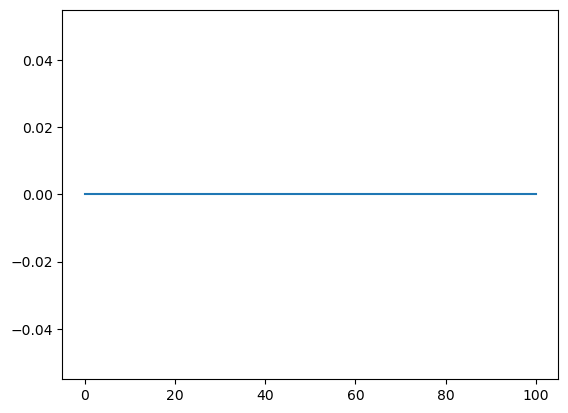

In [ ]:
from Redfield import Redfield as Redfield 



def DrudeLorenz(wk): # Spektrale dichte mit Drude lorenz bad auch genannt timura terminator. 
    if wk==0:
        return 2*np.pi * lam /(np.pi *gamma*beta)
    else:
        return 2*np.pi*(2.0*lam*gamma *wk /(np.pi*(wk**2+gamma**2))) * ((1/(np.exp((wk) * beta)-1))+1)

    
    
redfield_solver = Redfield(H=H_sys, rho0=rho0, Q=Q, a=P21, ad=P21, w0=w0, gamma=gamma, lam=lam, tlist=tlist,spectrum=DrudeLorenz)

    # Löse das System
rho_t_redfield = redfield_solver.Rsolver()

    # Plotte die Ergebnisse
    
fig, ax = plt.subplots()
ax.plot(rho_t_redfield.times, rho_t_redfield.expect[0],label='Redfield')
ax.plot(result.times, result.expect[0],'g',label='Lindblad') # Lindblad
ax.plot(result_HEOM.times, result_HEOM.e_data["a"], label="HEOM") #HEOM
plt.xlabel("Time")
plt.ylabel("Expectation value")
plt.legend()
print(lam)

In [ ]:
import numpy as np

# Parameter für die Korrelationsfunktion
gamma = 0.1  # Dämpfungsrate
omega_c = 1.0  # Charakteristische Frequenz (z.B. Schnittfrequenz des Bades)

# Lorentzförmige Korrelationsfunktion
def lorentz_correlation(t):
    return gamma * np.exp(-omega_c * np.abs(t))

# Zeitbereich für die Korrelationsfunktion
#tlist = np.linspace(0, 10, 100)

# Berechne die Korrelationsfunktion für die Zeitliste
C_t = lorentz_correlation(times)
bad4= BosonicBath(Q, C_t, vk_real, ck_imag, vk_imag)
solver = HEOMSolver(H_sys, Bad2, max_depth=max_depth, options=options)
# Plotten der Korrelationsfunktion
import matplotlib.pyplot as plt
plt.plot(tlist, C_t, label="Lorentz-Peak Correlation")
plt.xlabel("Time")
plt.ylabel("Correlation function")
plt.legend()
plt.show()

ValueError: The bath exponent lists ck_real and vk_real, and ck_imag and vk_imag must be the same length.

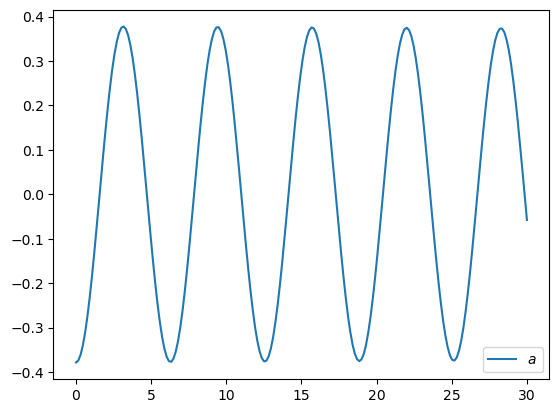

In [ ]:
N = 2
w0 = 1.0 #* 2 * np.pi
#g = 0.1 * w0
#kappa = 0.15
times = np.linspace(0, 30, 200)

def DrudeLorenz(wk):
    if wk==0:
        return 2*np.pi * lam /(np.pi *gamma*beta)
    else:
        return 2*np.pi*(2.0*lam*gamma *w /(np.pi*(w**2+gamma**2))) * ((1/(np.exp((w) * beta)-1))+1)

DL = (
    f"2*pi* 2.0 * {lam} / (pi * {gamma} * {beta}) if (w == 0) else "
    f"2*pi*(2.0*{lam}*{gamma} *w /(pi*(w**2+{gamma}**2))) * ((1/(exp((w) * {beta})-1))+1)"
)
options = Options(nsteps=15000, store_states=True,rtol=1e-12,atol=1e-12)


a = qutip.destroy(N)
H = w0 * a.dag() * a # + g * (a + a.dag())
rho0=qutip.coherent_dm(N, N)
#psi0 = qutip.ket2dm((basis(N, 4) + basis(N, 2) + basis(N, 0)).unit())
a_ops = [[g*(a+a.dag()), DrudeLorenz]]
e_ops = [ a.dag() ]

res_brme = qutip.brmesolve(H, rho0, times, a_ops,e_ops=e_ops)

plt.figure()
#plt.plot(times, res_brme.expect[0], label=r'$a^{+}a$')
plt.plot(times, res_brme.expect[0], label=r'$a$')
plt.legend()
plt.show()

    Parameters
    ----------
    H_sys : Qobj or QobjEvo or list
        The system Hamiltonian or Liouvillian. See :class:`HEOMSolver` for
        a complete description.

    coup_op : Qobj
        Operator describing the coupling between system and bath.
        See parameter ``Q`` in :class:`BosonicBath` for a complete description.

    coup_strength : float
        Coupling strength. Referred to as ``lam`` in :class:`DrudeLorentzBath`.

    temperature : float
        Bath temperature. Referred to as ``T`` in :class:`DrudeLorentzBath`.

    N_cut : int
        The maximum depth of the hierarchy. See ``max_depth`` in
        :class:`HEOMSolver` for a full description.

    N_exp : int
        Number of exponential terms used to approximate the bath correlation
        functions. The equivalent ``Nk`` in :class:`DrudeLorentzBath` is one
        less than ``N_exp`` (see note above).

    cut_freq : float
        Bath spectral density cutoff frequency. Referred to as ``gamma`` in
        :class:`DrudeLorentzBath`.

    bnd_cut_approx : bool
        Use boundary cut off approximation. If true, the Matsubara
        terminator is added to the system Liouvillian (and H_sys is
        promoted to a Liouvillian if it was a Hamiltonian). Keyword only.
        Default: False.

    options : dict, optional
        Generic solver options.
        If set to None the default options will be used. Keyword only.
        Default: None.

    combine : bool, default: True
        Whether to combine exponents with the same frequency (and coupling
        operator). See :meth:`BosonicBath.combine` for details.
        Keyword only. Default: True.
    """
    def __init__(
        self, H_sys, coup_op, coup_strength, temperature,
        N_cut, N_exp, cut_freq, *, bnd_cut_approx=False, options=None,
        combine=True,
    ):

In [ ]:
Stop 

NameError: name 'Stop' is not defined

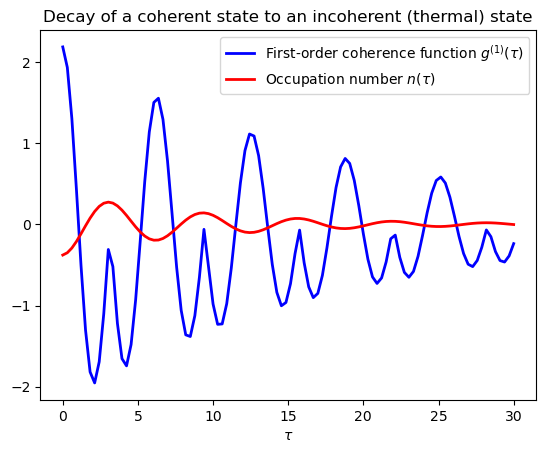

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import qutip


N = 2
taus = np.linspace(0.0,tmax,nt)
a = qutip.destroy(N)
H = w  * a.dag() * a

# collapse operator
G1 = g**2
n_th = nB  # bath temperature in terms of excitation number
c_ops = [np.sqrt(G1 * (1 + n_th)) * a, np.sqrt(G1 * n_th) * a.dag()]

# start with a coherent state
rho0 = qutip.coherent_dm(N, 2.0)

# first calculate the occupation number as a function of time
n = qutip.mesolve(H, rho0, taus, c_ops, [a]).expect[0]

# calculate the correlation function G1 and normalize with n to obtain g1
G1 = qutip.correlation_2op_1t(H, rho0, taus, c_ops, a.dag(), a)
g1 = np.array(G1) / np.sqrt(n[0] * np.array(n))

plt.plot(taus, np.real(g1), 'b', lw=2)
plt.plot(taus, n, 'r', lw=2)
plt.title('Decay of a coherent state to an incoherent (thermal) state')
plt.xlabel(r'$\tau$')
plt.legend([
    r'First-order coherence function $g^{(1)}(\tau)$',
    r'Occupation number $n(\tau)$',
])
plt.show()

[ 0.08005086+0.j          0.07960253+0.00806809j  0.07834367+0.01604586j
  0.07628776+0.02385208j  0.0734566 +0.03140738j  0.06987981+0.03863503j
  0.06559459+0.04546171j  0.06064532+0.05181826j  0.05508309+0.05764039j
  0.04896522+0.06286932j  0.04235458+0.06745237j  0.03531903+0.07134349j
  0.02793071+0.07450372j  0.02026525+0.07690161j  0.01240104+0.07851348j
  0.00441839+0.07932371j -0.0036012 +0.07932485j -0.01157601+0.07851771j
 -0.01942482+0.07691132j -0.02706777+0.07452286j -0.03442719+0.07137747j
 -0.04142839+0.06750795j -0.04800038+0.06295446j -0.05407663+0.05776408j
 -0.05959574+0.05199037j -0.06450203+0.04569273j -0.06874611+0.03893584j
 -0.07228541+0.03178906j -0.07508459+0.02432557j -0.07711588+0.01662175j
 -0.07835932+0.00875633j -0.07880307+0.00080965j -0.07844342-0.00713727j
 -0.07728482-0.01500345j -0.07533988-0.0227088j  -0.07262925-0.03017497j
 -0.0691813 -0.03732613j -0.0650319 -0.04408972j -0.06022405-0.05039725j
 -0.05480739-0.0561849j  -0.04883774-0.06139421j -0

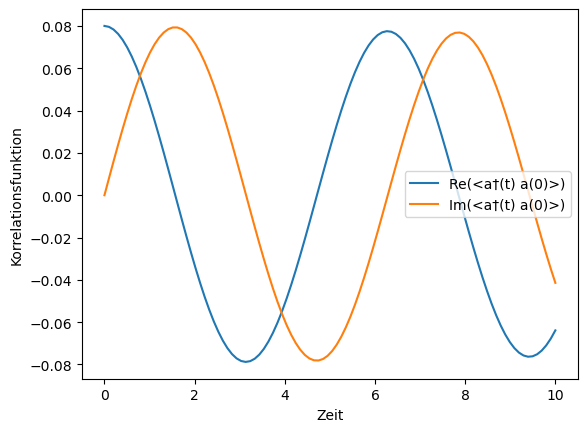

In [ ]:
from qutip import correlation_2op_1t, destroy, thermal_dm

import numpy as np
import matplotlib.pyplot as plt

# Parameter für das thermische Bad
N = 2  # Anzahl der Zustände
omega = w  # Frequenz des Systems
gamma2 = g**2  # Dämpfungsrate
beta = beta  # Inverse Temperatur (beta = 1/kT)

# Erzeuge den Vernichtungsoperator für das System
a = destroy(N)

# Thermischer Zustand des Systems
rho0 = thermal_dm(N, beta * omega)

# Hamiltonian des Systems (harmonischer Oszillator)
H = omega * a.dag() * a

# Lindblad-Operator (Dissipation)
L = np.sqrt(gamma2) * a

# Zeiten für die Berechnung der Korrelationsfunktion
times = np.linspace(0, 10, 100)

# Berechnung der Korrelationsfunktion <a†(t) a(0)> mit dem Hamiltonian H und Lindblad-Operator L
correlation_values = correlation_2op_1t(H, rho0, times, [L], a.dag(), a)
print(correlation_values)
# Ausgabe und Visualisierung der Korrelationsfunktion
plt.plot(times, np.real(correlation_values), label="Re(<a†(t) a(0)>)")
plt.plot(times, np.imag(correlation_values), label="Im(<a†(t) a(0)>)")
plt.xlabel('Zeit')
plt.ylabel('Korrelationsfunktion')
plt.legend()
plt.show()


In [ ]:
N_sys = 2
max_depth=2
nt = 100
tmax=30
tlist = [0, tmax, nt]
options = {"nsteps": 1500_000}
def proj(i, j):
    """ A helper function for creating an interaction operator. """
    return basis(N_sys, i) * basis(N_sys, j).dag()

# Construct one bath for each system state:
baths = []
for i in range(N_sys):
    Q = proj(i, i)
    baths.append(DrudeLorentzBath(Q, lam, gamma, T, Nk))

# Construct the system Liouvillian from the system Hamiltonian and
# bath expansion terminators:
H_sys = sum((i + 0.5) * w0* proj(i, i) for i in range(N_sys))
H_sys += sum(
  (i + j + 0.5) * g * proj(i, j)
  for i in range(N_sys) for j in range(N_sys)
  if i != j
)
HL = qutip.liouvillian(H_sys) + sum(bath.terminator()[1] for bath in baths)

# Construct the solver (pass a list of baths):
solver = HEOMSolver(HL, baths, max_depth=max_depth, options=options)

# Run the solver:
rho0 = basis(N_sys, 0) * basis(N_sys, 0).dag()
tlist = np.linspace(0, 5, 200)
e_ops = {
    f"P{i}": proj(i, i)
    for i in range(N_sys)
}
result = solver.run(rho0, tlist, e_ops=e_ops)

# Plot populations:
fig, axes = plt.subplots(1, 1, sharex=True, figsize=(8,8))
for label, values in result.e_data.items():
    axes.plot(result.times, values, label=label)
axes.set_xlabel(r't', fontsize=28)
axes.set_ylabel(r"Population", fontsize=28)
axes.legend(loc=0, fontsize=12)

In [ ]:
#Bad underdumped 

def cot(x):
    """ Vectorized cotangent of x. """
    return 1. / np.tan(x)

def coth(x):
    """ Vectorized hyperbolic cotangent of x. """
    return 1. / np.tanh(x)

def underdamped_matsubara_params(lam, gamma, T, nk):
    """ Calculation of the real and imaginary expansions of the underdamped correlation functions.
    """
    Om = np.sqrt(w0**2 - (gamma / 2)**2)
    Gamma = gamma / 2.
    beta = 1. / T

    ckAR = [
        (lam**2 / (4*Om)) * coth(beta * (Om + 1.0j * Gamma) / 2),
        (lam**2 / (4*Om)) * coth(beta * (Om - 1.0j * Gamma) / 2),
    ]
    ckAR.extend(
        (-2 * lam**2 * gamma / beta) * (2 * np.pi * k / beta) / 
        (((Om + 1.0j * Gamma)**2 + (2 * np.pi * k / beta)**2) *
         ((Om - 1.0j * Gamma)**2 + (2 * np.pi * k / beta)**2)) + 0.j
        for k in range(1, nk + 1)
    )
    vkAR = [
        -1.0j * Om + Gamma,
        1.0j * Om + Gamma,
    ]
    vkAR.extend(
        2 * np.pi * k * T + 0.j
        for k in range(1, nk + 1)
    )

    factor = 1. / 4

    ckAI = [
        -factor * lam**2 * 1.0j / Om,
        factor * lam**2 * 1.0j / Om,
    ]
    vkAI = [
        -(-1.0j * Om - Gamma),
        -(1.0j * Om - Gamma),
    ]
    
    return ckAR, vkAR, ckAI, vkAI

ckAR, vkAR, ckAI, vkAI = underdamped_matsubara_params(lam=lam, gamma=gamma, T=T, nk=Nk)

options = Options(nsteps=15000, store_states=True, rtol=1e-14, atol=1e-14)

def timer(label):
    """ Simple utility for timing functions:
    
        with timer("name"):
            ... code to time ...
    """
    start = time.time()
    yield
    end = time.time()
    print(f"{label}: {end - start}")


Badunder = BosonicBath(Q, ckAR, vkAR, ckAI, vkAI)
#HEOMMats = HEOMSolver(H_sys, Badunder, 5, options=options)
    

max_depth=4

#Gibt einen  ausdruck der zeit an. 

# times to evaluate the system state at
#result = solver.run(rho0, tlist)
# Define the operators that measure the populations of the two
# system states:
P11p = basis(2,0) * basis(2,0).dag()
P22p = basis(2,1) * basis(2,1).dag()

# Define the operator that measures the 0, 1 element of density matrix
# (corresonding to coherence):


# Define the operators that measure the populations of the two
# system states:
P11p = basis(2,0) * basis(2,0).dag()
P22p = basis(2,1) * basis(2,1).dag()
E=basis(2,1) * basis(2,1).dag()*(basis(2,1) * basis(2,1).dag()).dag()
# Define the operator that measures the 0, 1 element of density matrix
# (corresonding to coherence):
P12p = basis(2,0) * basis(2,1).dag()
P21p = basis(2,1) * basis(2,0).dag()
# Run the solver:


#result_HEOM = HEOMMats.run(rho0, tlist, e_ops={"22": P22p})

fig, axes = plt.subplots(1, 1, sharex=True, figsize=(8,8))
#axes.plot(result_HEOM.times, result_HEOM.e_data["22"], 'b', linewidth=2, label="22")
#axes.plot(result_HEOM.times, (np.abs(result_HEOM.e_data["E"]))**2, 'r', linewidth=2, label="E(t)²")
    